In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
mpl.style.use('seaborn')
plt.rcParams['axes.facecolor'] = '#f0f4f7'
plt.rc('legend', frameon=True,fancybox=True, framealpha=1)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

blue = '#4C72B0'
green = '#55A868'
red = '#C44E52'
purple = '#8172B2'
yellow = '#CCB974'
lightblue = '#64B5CD'

import importlib
import os
from os import path
import sys
import platform
import qgrid

import dill as pickl

from sync_class import SyncPhenosys
from eda_class import SpikesEDA
from behavior_class import BehaviorAnalysis
from sda_class import SpikesSDA
from report_class import SpikesReport

from analyze_phenosys import *

from projectthesis_plots import *

from sync_postprocessing import *

%load_ext autoreload
%autoreload 2


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


import warnings
warnings.filterwarnings('ignore')


window = 2000
iterations = 1000
bins = 50


# list -> [ session_name, [ttl_missing_rows], load_spikes, [spikes_trials_skip] ]
se_li = [('JG14_190621', [1900,1931,1996,2058,2127],True,[(0,6),(215,'end')]),
         ('JG14_190619', [111, 2781],False,[(0,1),(259,'end')]),
         ('JG14_190626', [1428, 1824, 1838, 2861, 2910, 3089, 3245, 3430, 3443],False,[(0,1),(276,'end')]),
         ('JG15_190722', [2094, 2574, 2637, 2808, 2831, 3499],False,[(271,'end')]),
         ('JG15_190725', [366,711,1487,1578,1659,2221,2666,2720,2769,2847,3371,3476],False,[(184,'end')]),
         ('JG18a_190814', [405,2621,2693,2770,2959,3015,3029,3038,3048],False,[(307,'end')]),
         ('JG18b_190828', [1744, 2363, 2648, 2701, 2731, 2778,2953,2967],True,[(0,0),(204,'end')]),
         ]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
%time
all_sessions_dict = dict()
# load all sessions into dict
for session_name,missing_rows_ttl,load_spikes,spikes_trials_skip in se_li:
    all_sessions_dict[session_name]=load_session(session_name, missing_rows_ttl, load_spikes, spikes_trials_skip)


all_sessions_dict['JG15_190722'].sync.combined_df.loc[(131,32,428,6),"Delta (TTL-CSV)"]=30

sessions_info_df=get_trial_info(all_sessions_dict)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
JG14_190621 -> sda
JG14_190619 -> behavior
JG14_190626 -> behavior
JG15_190722 -> behavior
JG15_190725 -> behavior
JG18a_190814 -> behavior
JG18b_190828 -> sda


# Chapter Results Sync Phenosys

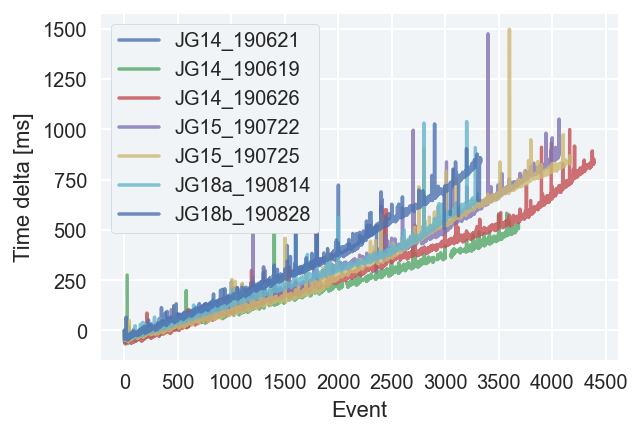

In [65]:
fig,ax = plt_trial_length(all_sessions_dict,figsize=set_size(0.8))
save_fig("ttl_delta", fig)

y = 0.20581 * x + 0.00002 * x^2 + -27.62327
y = 0.16904 * x + 0.00001 * x^2 + -46.18029
y = 0.15881 * x + 0.00002 * x^2 + -41.63060
y = 0.12846 * x + 0.00003 * x^2 + -18.38659
y = 0.12831 * x + 0.00003 * x^2 + -35.83041
y = 0.11275 * x + 0.00003 * x^2 + -15.81575
y = 0.16590 * x + 0.00004 * x^2 + -15.16294


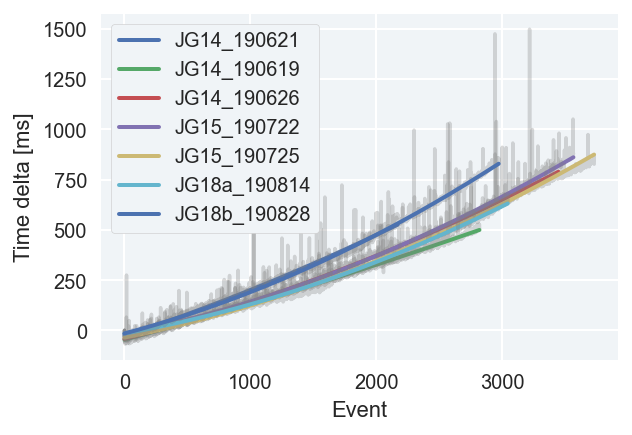

In [66]:
fig,ax = plt.subplots(1,1,figsize=set_size(0.8))
max_x = 0
fit_curves_pol = list()

for key,se in all_sessions_dict.items():
    x,y,x_line,y_line = fit_curve(se,'pol')
    label=se.sync.session
    plt_fit_curve(ax,x,y,x_line,y_line,label)
    fit_curves_pol.append([label,x,y,x_line,y_line])
    
ax.set_xlabel("Event")
ax.set_ylabel("Time delta [ms]")
ax.legend(loc=2)

save_fig("ttl_delta_fitted_pol", fig)

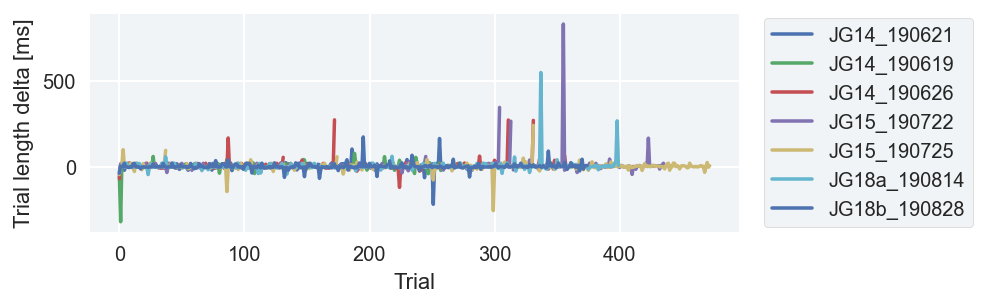

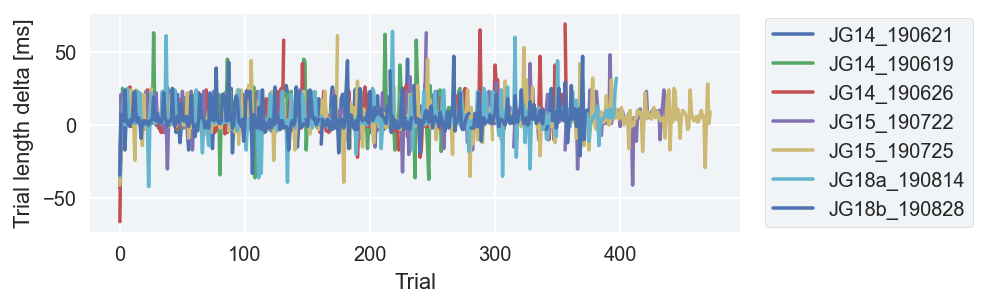

In [67]:
fig,ax = plt_trial_length_dif(all_sessions_dict,outlier=True,figsize=set_size(1.1))
save_fig("trial_length_all", fig)

fig, ax = plt_trial_length_dif(all_sessions_dict,figsize=set_size(1.1))
save_fig("trial_length_nooutlier", fig)

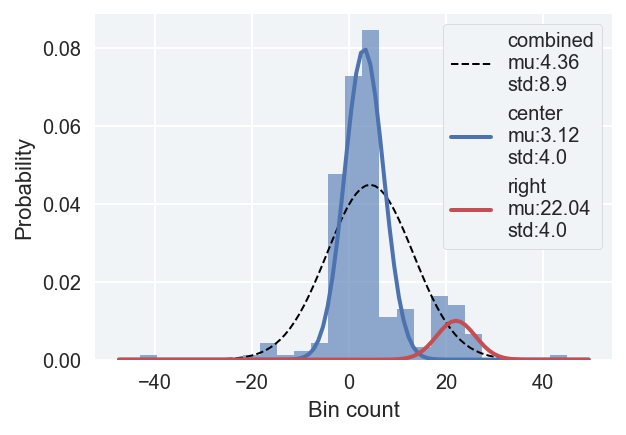

In [68]:
length_df = get_trial_length_dif(all_sessions_dict['JG14_190621'])

fig,ax = plt_fit_normdist(length_df["trial length cor"].dropna(), figsize=set_size(0.8))
save_fig("trial_length_norm", fig)



In [69]:
all_sessions_trial_info_df=list()
for key,se in all_sessions_dict.items():
    all_sessions_trial_info_df.append(get_trial_length_dif(se))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


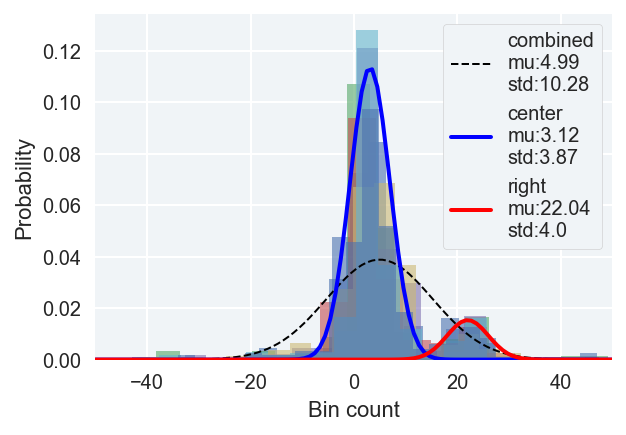

In [70]:
all_list = list()

fig,ax = plt.subplots(1,1,figsize=set_size(0.8))

for length_df in all_sessions_trial_info_df:
    ax = plt_fit_normdist(length_df["trial length cor"].dropna(),ax,norm_fit=False)
    all_list.extend(length_df["trial length cor"].dropna().values)

legend = ax.get_legend()
legend.remove()

ax.set_xlim([-50, 50])

# plot combined fit
mu, std = norm.fit(all_list)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, "k", linestyle='--', linewidth=1,label=f"combined\nmu:{round_up(mu,2)}\nstd:{round_up(std,2)}")

# center
mu=3.12
std=3.87
#x = np.linspace(-25, 29, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p*1.1, "blue", linestyle='-', linewidth=2,label=f"center\nmu:{round_up(mu,2)}\nstd:{round_up(std,2)}")

# right
mu=22.04
std=4
p = norm.pdf(x, mu, std)
#x = np.linspace(12, 33, 100)
ax.plot(x, p/6.5, "red", linestyle='-', linewidth=2,label=f"right\nmu:{round_up(mu,2)}\nstd:{round_up(std,2)}")

ax.legend() #prop={'size': 14}

save_fig("trial_length_norm_all", fig)

In [71]:
event_dif_df = get_event_df(all_sessions_dict)

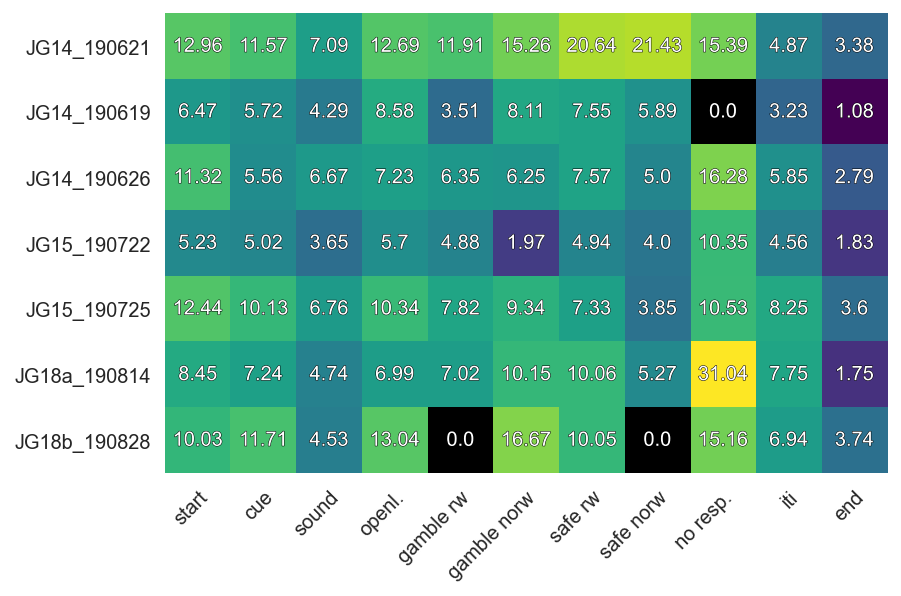

In [72]:
fig, ax = fingerprint_color_map(event_dif_df,figsize=set_size(1.1))
save_fig("event_type_dif", fig)

# Results New System

In [2]:
# windows
#openephys_dir = r"C:\maxland_RECORDING\openephys\2021-02-19_15-54-34\Record Node 101\experiment1\recording1"

# mac
openephys_dir = "/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/2 VR Setup/Software/PyBpod Environments/maxland_test_setup/openephys/2021-02-19_15-54-34/Record Node 101/experiment1/recording1"

pybpod_session = "20210219-155417"

# windows
#pybpod_root = r"C:\maxland_RECORDING"

# mac
pybpod_root = "/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/2 VR Setup/Software/PyBpod Environments/maxland_test_setup"

In [21]:
all_newsessions_dict = dict()
all_newsessions_dict['test1']=combined_df = get_sync(openephys_dir,pybpod_root,pybpod_session)

test1_df=all_newsessions_dict['test1']

In [22]:
qgrid.show_grid(test1_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

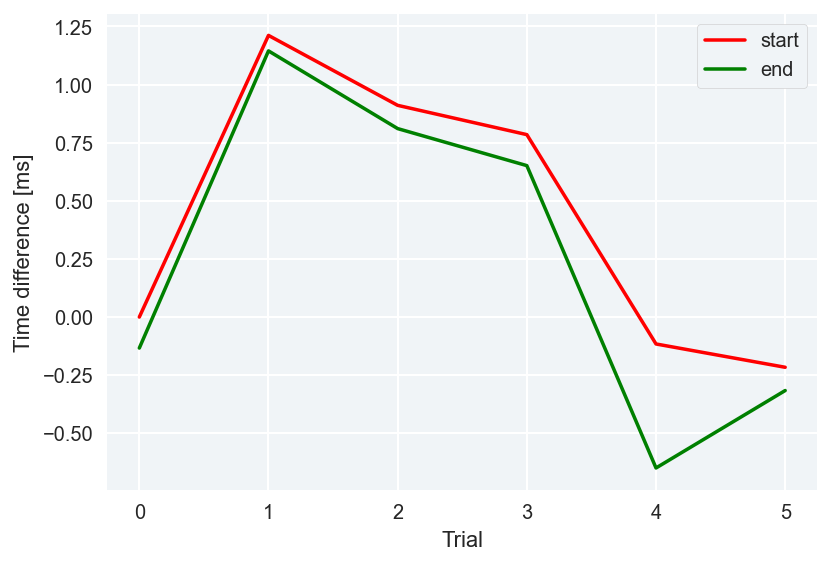

In [29]:
fig,ax = plt_start_stop_dif(test1_df,figsize=set_size(1.1))

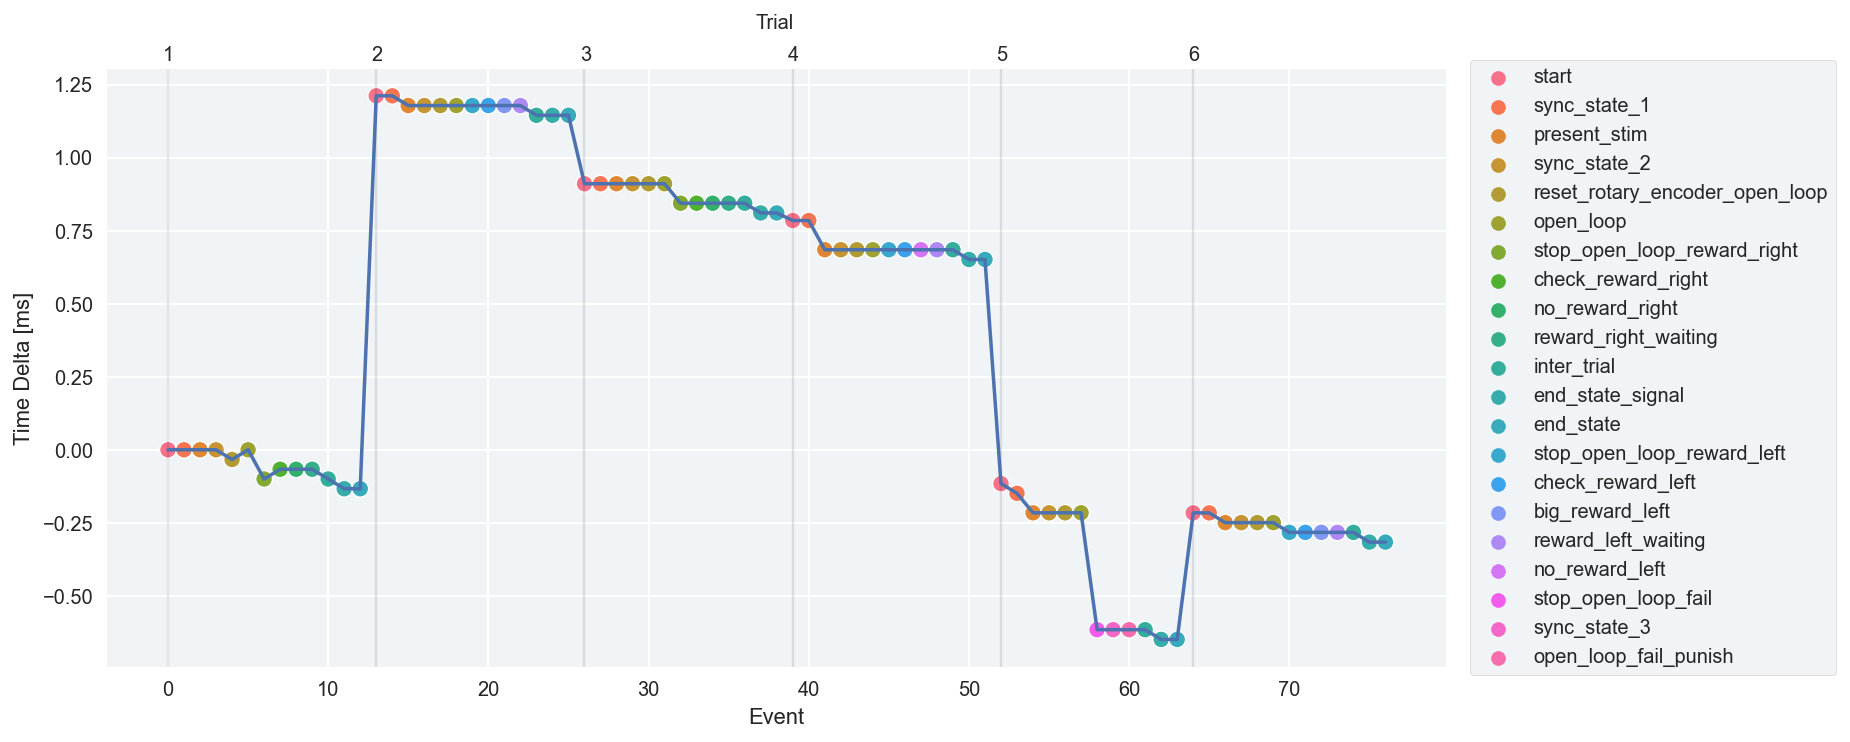

In [23]:
fig,ax = plt_event_dif(test1_df,all=False)

In [26]:
combined_df = test1_df
test1_df

,oe_ms_relativ,pb_ms_relativ,oe_event,pb_event,delta_pb_oe
0,0.000000,0.000000,start,start,0.000000
1,0.100000,0.100000,event,sync_state_1,0.000000
2,0.200000,0.200000,event,reset_rotary_encoder_wheel_stopping_check,0.000000
3,0.300000,0.300000,event,wheel_stopping_check,0.000000
4,1000.300000,1000.300000,event,present_stim,0.000000
...,...,...,...,...,...
1228,54467.866667,54467.583984,reward_event,big_reward_left,-0.282682
1229,54567.866667,54567.583984,event,reward_left_waiting,-0.282682
1230,55467.866667,55467.583984,event,inter_trial,-0.282682
1231,56967.900000,56967.583984,event,end_state_signal,-0.316016


In [27]:
start=(combined_df.loc[combined_df['pb_event']=='New trial']).copy()
start.reset_index(inplace=True,drop=True)
stop=(combined_df.loc[combined_df['pb_event']=='The trial ended']).copy()
stop.reset_index(inplace=True,drop=True)

In [28]:
start

,oe_ms_relativ,pb_ms_relativ,oe_event,pb_event,delta_pb_oe


In [32]:
all_sessions_dict['JG15_190722'].sync.combined_df

TTL Start  TTL Length  \
All Trial Trial index Group Index                           
0.0       0.0   0     0              328943.0        11.0   
                1     1              349155.0        40.0   
                2     2              349815.0        60.0   
                3     3              350515.0        80.0   
                4     4              355659.0        96.0   
...                                       ...         ...   
936.0     438.0 4065  3            41063014.0        80.0   
                4066  4            41203122.0       180.0   
                4067  5            41203323.0       200.0   
                4068  6            41203542.0       220.0   
NaN       NaN   4069  0            41203803.0       118.0   

                                             TTL Event  TTL Start norm  \
All Trial Trial index Group Index                                        
0.0       0.0   0     0                          start             0.0   
                1     1                            cue         20212.0   
                2     2                          sound         20872.0   
                3     3                       openloop         21572.0   
                4     4                       right_rw         26716.0   
...                                                ...             ...   
936.0     438.0 4065  3                       openloop      40734071.0   
                4066  4            no response in time      40874179.0   
                4067  5                            iti      40874380.0   
                4068  6                            end      40874599.0   
NaN       NaN   4069  0                     right_norw      40874860.0   

                                   TTL index   CSV Start            CSV Event  \
All Trial Trial index Group Index                                               
0.0       0.0   0     0                  0.0     14559.0                start   
                1     1                  1.0     34799.0                  cue   
                2     2                  2.0     35459.0                sound   
                3     3                  3.0     36159.0             openloop   
                4     4                  4.0     41299.0             right_rw   
...                                      ...         ...                  ...   
936.0     438.0 4065  3               3567.0  40747579.0             openloop   
                4066  4               3568.0  40887859.0  no response in time   
                4067  5               3569.0  40888059.0                  iti   
                4068  6               3570.0  40888279.0                  end   
NaN       NaN   4069  0               3571.0  40888539.0                start   

                                  CSV Probability  CSV Start norm  CSV index  \
All Trial Trial index Group Index                                              
0.0       0.0   0     0                     0.125             0.0        0.0   
                1     1                     0.125         20240.0        1.0   
                2     2                     0.125         20900.0        2.0   
                3     3                     0.125         21600.0        3.0   
                4     4                     0.125         26740.0        4.0   
...                                           ...             ...        ...   
936.0     438.0 4065  3                     0.750      40733020.0     3567.0   
                4066  4                     0.750      40873300.0     3568.0   
                4067  5                     0.750      40873500.0     3569.0   
                4068  6                     0.750      40873720.0     3570.0   
NaN       NaN   4069  0                     0.750      40873980.0     3571.0   

                                   Delta (TTL-CSV) Compare Good Trial  
All Trial Trial index Group Index                                      
0.0       0.0   0     0                 

In [33]:
test1_df

,oe_ms_relativ,pb_ms_relativ,oe_event,pb_event,delta_pb_oe
0,0.000000,0.000000,start,start,0.000000
1,0.100000,0.100000,event,sync_state_1,0.000000
2,0.200000,0.200000,event,reset_rotary_encoder_wheel_stopping_check,0.000000
3,0.300000,0.300000,event,wheel_stopping_check,0.000000
4,1000.300000,1000.300000,event,present_stim,0.000000
...,...,...,...,...,...
1228,54467.866667,54467.583984,reward_event,big_reward_left,-0.282682
1229,54567.866667,54567.583984,event,reward_left_waiting,-0.282682
1230,55467.866667,55467.583984,event,inter_trial,-0.282682
1231,56967.900000,56967.583984,event,end_state_signal,-0.316016


In [63]:
pb_events_df = load_bp_events(pybpod_root,pybpod_session)
# extract states
states_df = pb_events_df.loc[pb_events_df.TYPE=='STATE']
states_df = states_df.dropna(axis=0,how='any')

starts = pb_events_df.loc[pb_events_df.loc[(pb_events_df.TYPE=='TRIAL')].index,'ms_relativ'].copy()
starts.reset_index(inplace=True,drop=True)

start_idx = -1
trial=False
for idx in states_df.index:
    if states_df.loc[idx,'BPOD-INITIAL-TIME']==0:
        start_idx+=1
    states_df.loc[idx,'ms_relativ']=states_df.loc[idx,'BPOD-INITIAL-TIME']*1000+starts.loc[start_idx]

pb_sync_df = states_df#states_df.loc[:,["MSG","ms_relativ","BPOD-INITIAL-TIME"]]


# load openephys ttl
oe_events_df = load_oo_events(openephys_dir)
# conver ttl to events
oe_trials_df = extract_events_oo(oe_events_df)
# remove end
oe_end_idx = oe_trials_df.loc[oe_trials_df.event_type=='end'].index
not_select = oe_trials_df.index.isin(oe_end_idx.values-1)
oe_trials_df = oe_trials_df.loc[~not_select]

#oe_trials_df=oe_trials_df.loc[np.invert(oe_trials_df.event_type=='end')]


"""old
# create combined df
# select bpod necessary files
selector = np.logical_or(np.logical_or(pb_events_df.TYPE=="TRANSITION",pb_events_df.TYPE=="TRIAL"),pb_events_df.TYPE=="END-TRIAL")
pb_sync_df = pb_events_df.loc[selector,["MSG","ms_relativ","BPOD-INITIAL-TIME"]]
# combine both
combined_ar = np.zeros([pb_sync_df.shape[0],4],dtype=object)
combined_ar[:oe_trials_df.shape[0],[0,2]]=oe_trials_df.values
combined_ar[:pb_sync_df.shape[0],[1,3]]=pb_sync_df.loc[:,["ms_relativ","MSG"]].values
combined_df=pd.DataFrame(combined_ar,columns=["oe_ms_relativ","pb_ms_relativ","oe_event","pb_event"])
combined_df["delta_pb_oe"]=combined_df["pb_ms_relativ"]-combined_df["oe_ms_relativ"]
"""


# create combined
combined_ar = np.zeros([pb_sync_df.shape[0],11],dtype=object)
combined_ar[:oe_trials_df.shape[0],0:2]=oe_trials_df.values
combined_ar[:pb_sync_df.shape[0],2:11]=pb_sync_df.values
combined_df=pd.DataFrame(combined_ar,columns=["TTL Start norm","TTL Event","CSV Type","CSV Pctime","CSV in trial start","CSV in trial end",
                                               "CSV Event","CSV info","CSV Datetime","CSV Start","CSV Start norm"])
combined_df["Delta (TTL-CSV)"]=combined_df["TTL Start norm"]-combined_df["CSV Start norm"]

# model like phenosys sync df for futher analysis
combined_df.reset_index(inplace=True,drop=True)
#combined_df.pb

In [66]:
combined_df

,TTL Start norm,TTL Event,CSV Type,CSV Pctime,CSV in trial start,CSV in trial end,CSV Event,CSV info,CSV Datetime,CSV Start,CSV Start norm,Delta (TTL-CSV)
0,0.000000,start,STATE,2021-02-19 15:54:47.053757,0.0000,0.0001,start,0.0001,2021-02-19 15:54:47.053757,1613750087053.756836,0.000000,0.000000
1,0.100000,event,STATE,2021-02-19 15:54:47.053757,0.0001,0.0002,sync_state_1,0.0001,2021-02-19 15:54:47.053757,1613750087053.756836,0.100000,0.000000
2,0.200000,event,STATE,2021-02-19 15:54:47.053757,0.0002,0.0003,reset_rotary_encoder_wheel_stopping_check,0.00010000000000000002,2021-02-19 15:54:47.053757,1613750087053.756836,0.200000,0.000000
3,0.300000,event,STATE,2021-02-19 15:54:47.053757,0.0003,1.0003,wheel_stopping_check,1.0,2021-02-19 15:54:47.053757,1613750087053.756836,0.300000,0.000000
4,1000.300000,event,STATE,2021-02-19 15:54:47.053757,1.0003,1.0004,present_stim,9.999999999998899e-05,2021-02-19 15:54:47.053757,1613750087053.756836,1000.300000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1228,54467.866667,reward_event,STATE,2021-02-19 15:55:37.032944,2.9190,3.0190,big_reward_left,0.10000000000000009,2021-02-19 15:55:37.032944,1613750137032.943848,54467.583984,0.282682
1229,54567.866667,event,STATE,2021-02-19 15:55:37.032944,3.0190,3.9190,reward_left_waiting,0.8999999999999999,2021-02-19 15:55:37.032944,1613750137032.943848,54567.583984,0.282682
1230,55467.866667,event,STATE,2021-02-19 15:55:37.032944,3.9190,5.4190,inter_trial,1.5000000000000004,2021-02-19 15:55:37.032944,1613750137032.943848,55467.583984,0.282682
1231,56967.900000,event,STATE,2021-02-19 15:55:37.032944,5.4190,5.4191,end_state_signal,9.999999999976694e-05,2021-02-19 15:55:37.032944,1613750137032.943848,56967.583984,0.316016


In [69]:
combined_df.loc[:,["TTL Start norm","TTL Event", "CSV Event","CSV Start norm"]]

,TTL Start norm,TTL Event,CSV Event,CSV Start norm
0,0.000000,start,start,0.000000
1,0.100000,event,sync_state_1,0.100000
2,0.200000,event,reset_rotary_encoder_wheel_stopping_check,0.200000
3,0.300000,event,wheel_stopping_check,0.300000
4,1000.300000,event,present_stim,1000.300000
...,...,...,...,...
1228,54467.866667,reward_event,big_reward_left,54467.583984
1229,54567.866667,event,reward_left_waiting,54567.583984
1230,55467.866667,event,inter_trial,55467.583984
1231,56967.900000,event,end_state_signal,56967.583984


(-1.3044677734377275, 0.7420979817769421)

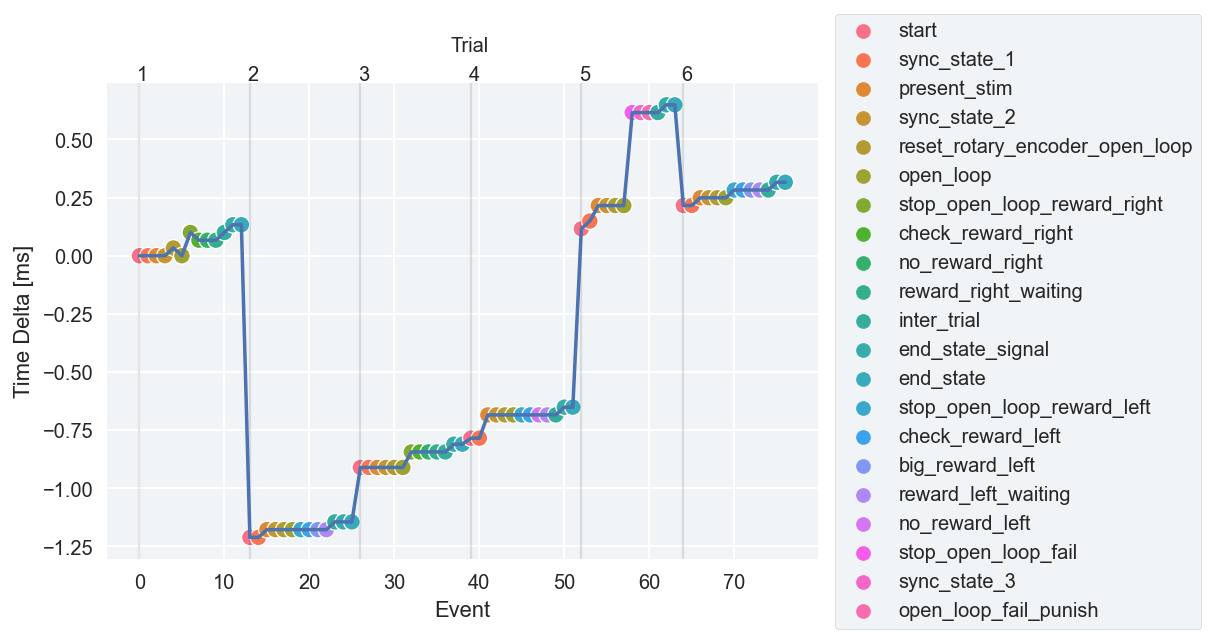

In [72]:
plot_all=False


data = combined_df.loc[:,["TTL Start norm","TTL Event", "CSV Event","CSV Start norm","Delta (TTL-CSV)"]].copy()
data.columns=['oe_ms_relativ','oe_event','pb_event','pb_ms_relativ','delta_pb_oe']

if not(plot_all):
    not_list = ['wheel_stopping_check','wheel_stopping_check_failed_punish','wheel_stopping_check_failed_reset','reset_rotary_encoder_wheel_stopping_check']
    bool_filter = ~data.pb_event.isin(not_list)
    data = data.loc[bool_filter].copy()
    data.reset_index(inplace=True,drop=True)
    data.delta_pb_oe = data.delta_pb_oe.astype(float)
else:
    data.delta_pb_oe = data.delta_pb_oe.astype(float)

new_trial = data.loc[data.pb_event=='start']

fig,ax = plt.subplots(figsize=figsize)
# scatterplot with color
g = sns.scatterplot(data=data, x=data.index, y='delta_pb_oe', hue='pb_event', s=70)
# connect dots
sns.lineplot(data=data.delta_pb_oe)
# add trial start lines
line_min , line_max = ax.get_ylim()#data.delta_pb_oe.max()
#line_min = #data.delta_pb_oe.min()
plt.vlines(new_trial.index.values, line_min, line_max, linestyle='-',alpha=0.1,color='k',linewidth=1.2) #,label='New trial'
# trial 2nd x axis
trial=1
for trial_idx in new_trial.iterrows():
    ax.text(trial_idx[0]-0.3, line_max+(line_max/50), f"{trial}")
    trial+=1

# move index outside
g.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))

ax.set_ylabel('Time Delta [ms]')
ax.set_xlabel('Event')
# second x label
fig.text(0.5,0.93,"Trial")

# set y lims
ax.set_ylim(line_min,line_max)